In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import numpy.linalg
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
from networkx.algorithms import community
import itertools

In [2]:
#df = pd.DataFrame(arff.loadarff("2d-10c.arff")[0])
#df = pd.DataFrame(arff.loadarff("3-spiral.arff")[0])
#df = pd.DataFrame(arff.loadarff("dense-disk-5000.arff")[0])
df = pd.DataFrame(arff.loadarff("../data/artificial/cluto-t4-8k.arff")[0])
#df = pd.DataFrame(arff.loadarff("2sp2glob.arff")[0])
#df = pd.DataFrame(arff.loadarff("diamond9.arff")[0])
#df["CLASS"] = df["class"]
df["CLASS"] = df["CLASS"].map({x: i for i, x in enumerate(df["CLASS"].unique())})
df

,x,y,CLASS
0,68.601997,102.491997,0
1,454.665985,264.808990,1
2,101.283997,169.285995,2
3,372.614990,263.140991,1
4,300.989014,46.555000,3
...,...,...,...
7995,442.420990,303.721985,2
7996,495.451996,288.502991,2
7997,267.605011,141.725006,4
7998,238.358002,252.729996,4


In [3]:
#X = df[["a0", "a1"]].to_numpy()
X = df[["x", "y"]].to_numpy()

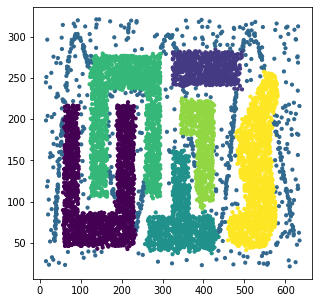

In [4]:
plt.figure(figsize=(5, 5))
#plt.scatter(df["a0"], df["a1"], c=df["CLASS"], s=[10] * len(X))
plt.scatter(df["x"], df["y"], c=df["CLASS"], s=10)

In [5]:
k = 10

In [6]:
distance_matrix = euclidean_distances(X, X)

In [7]:
def build_k_nearest_neighbor_graph(X, k, d):
    graph = nx.Graph()

    for i in X:
        graph.add_node(i)

    for a in X:
        for b in np.argsort(distance_matrix[a])[1:k + 1]:
            graph.add_edge(a, b, weight=d[a][b], similarity=1/d[a][b])

    return graph

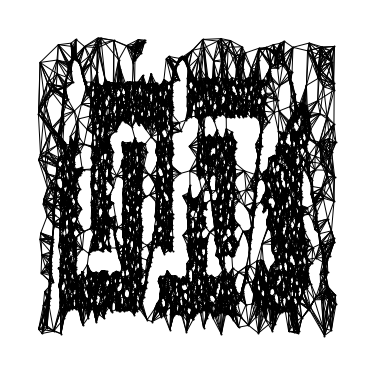

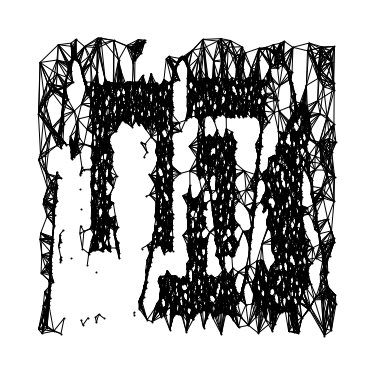

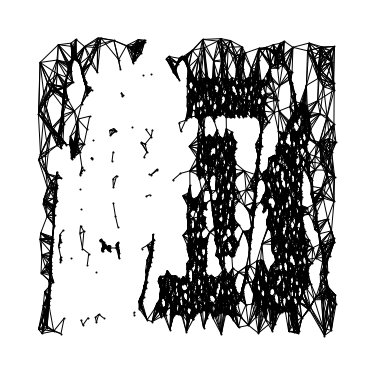

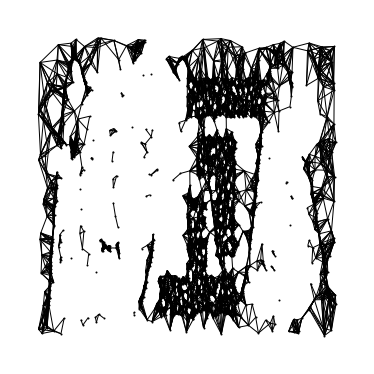

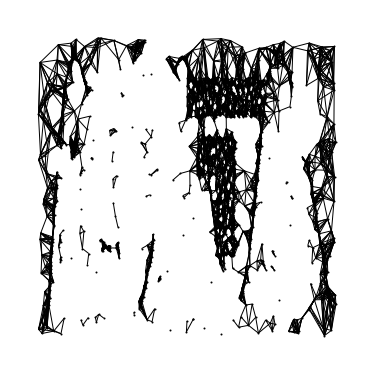

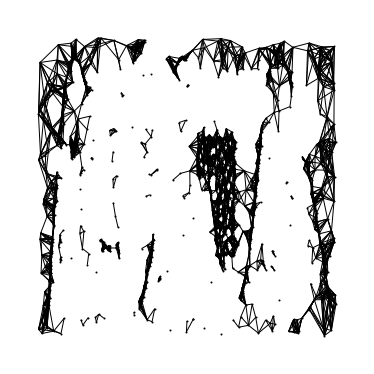

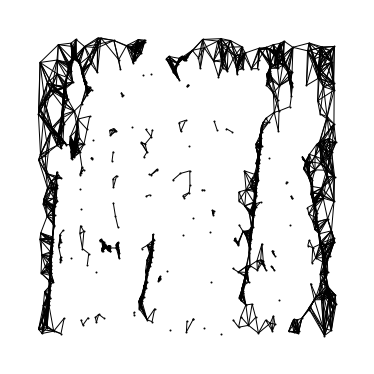

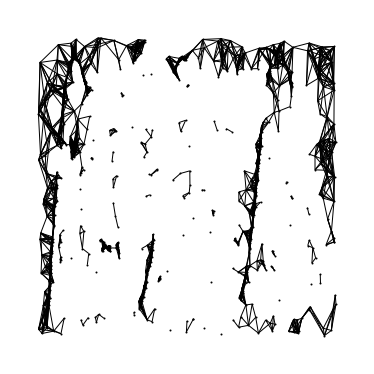

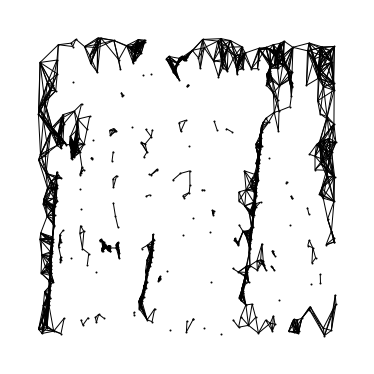

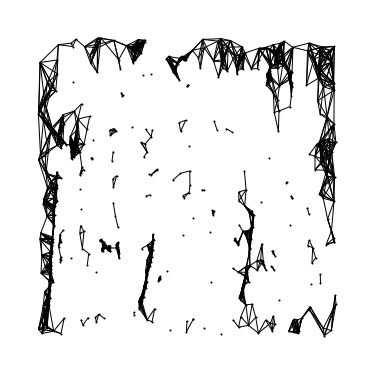

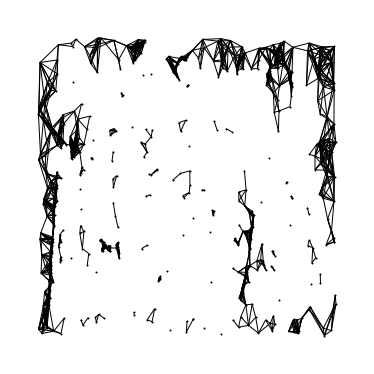

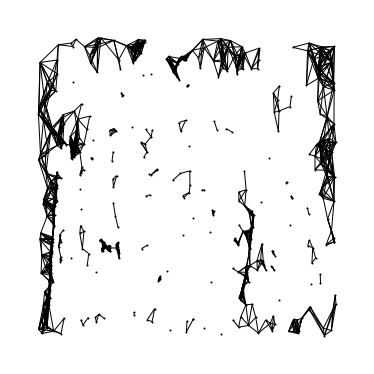

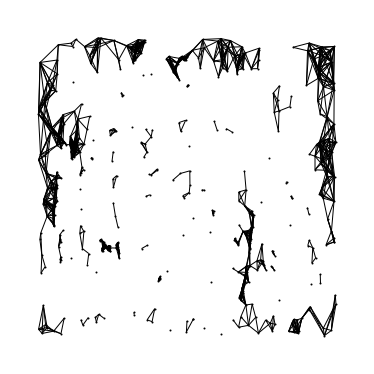

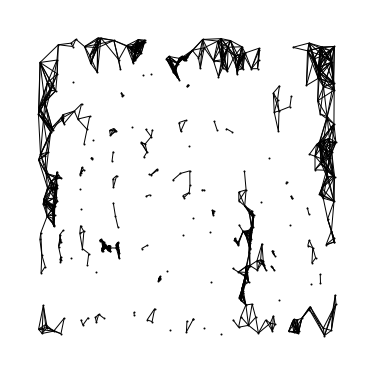

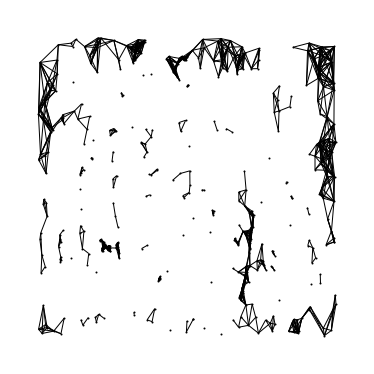

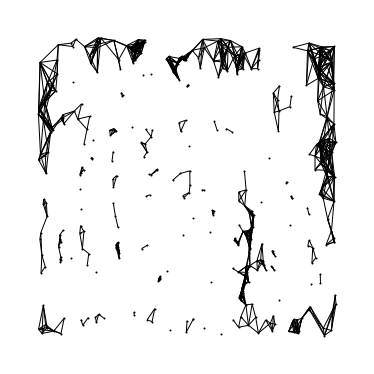

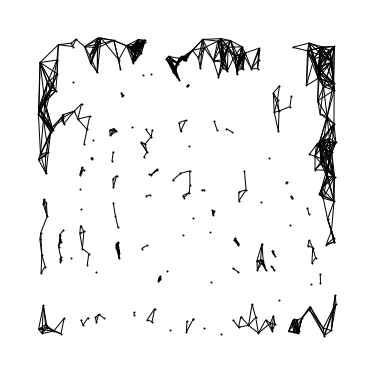

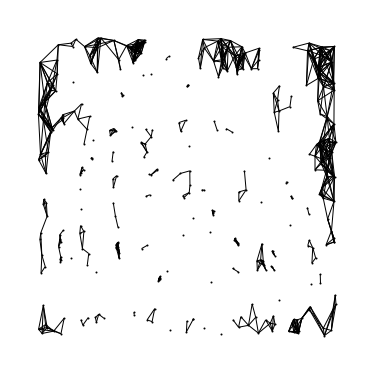

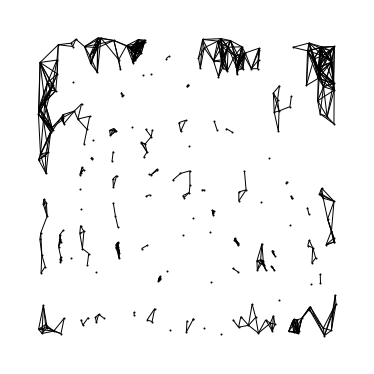

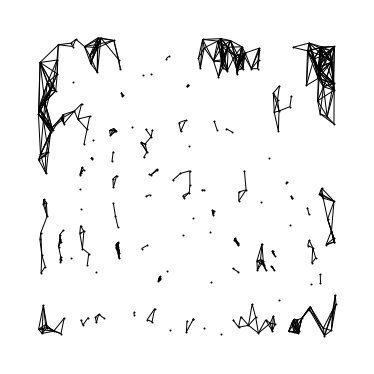

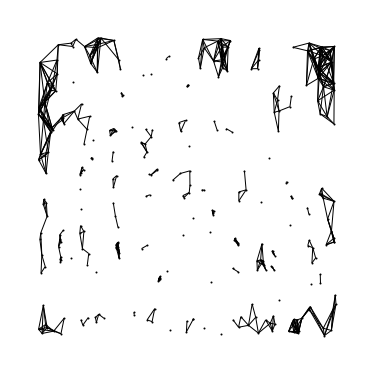

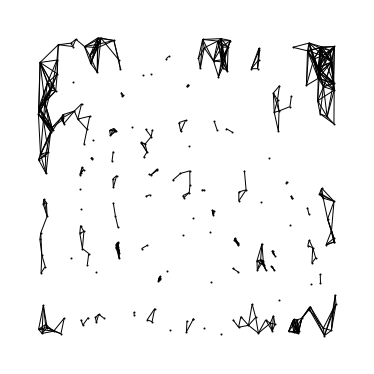

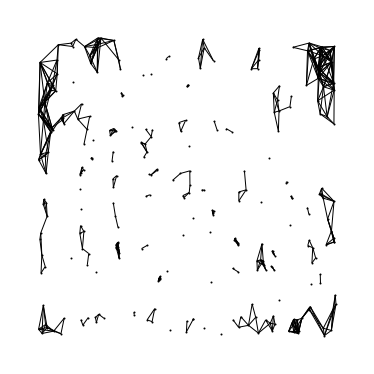

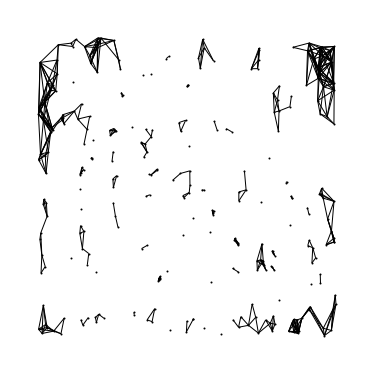

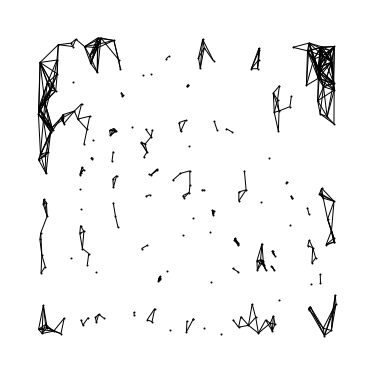

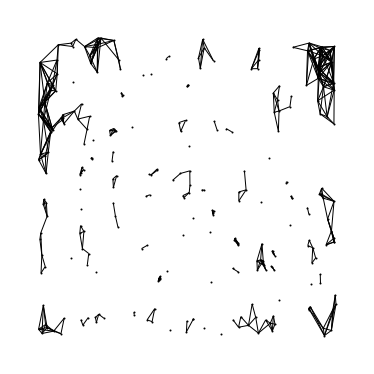

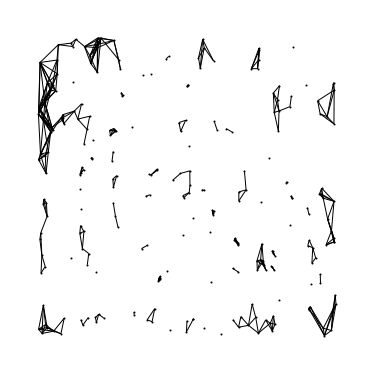

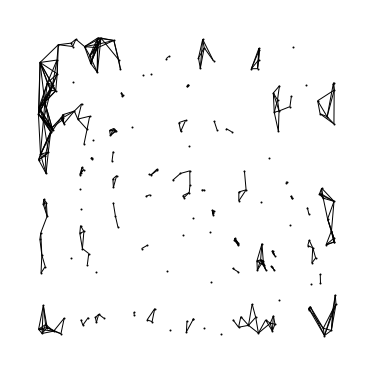

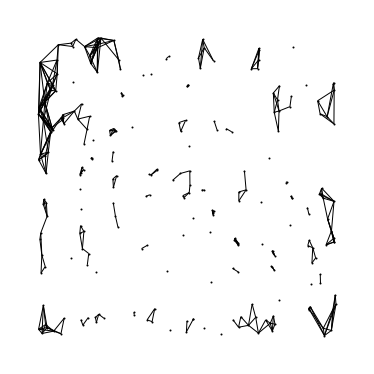

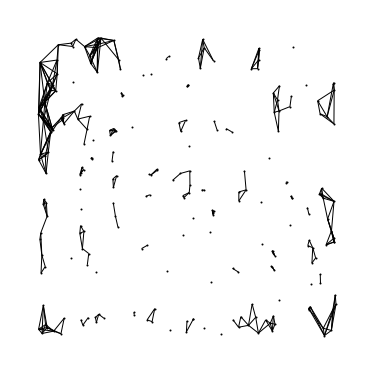

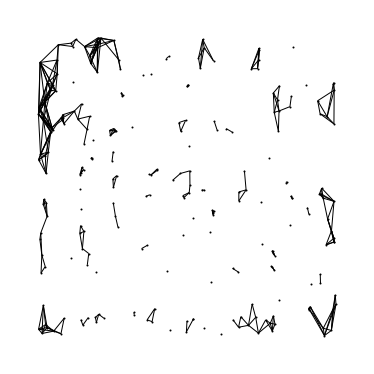

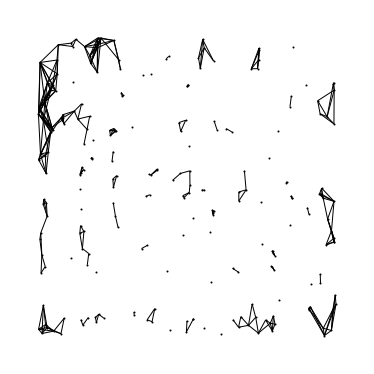

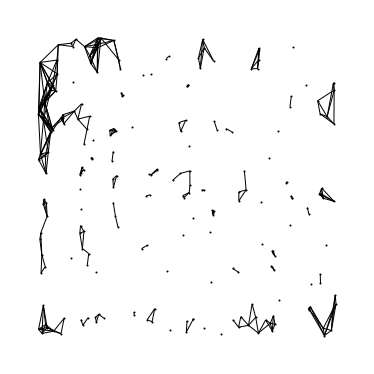

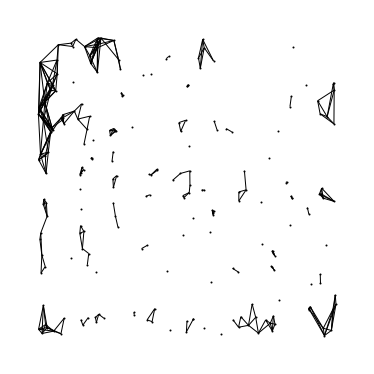

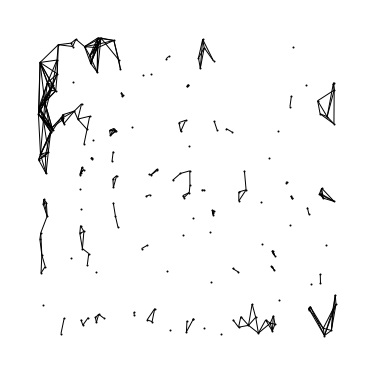

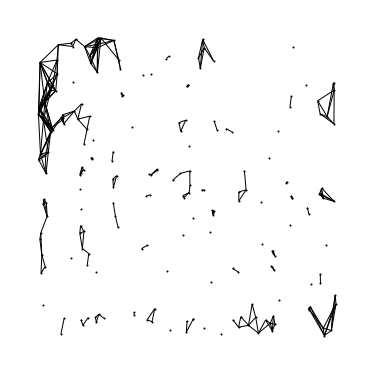

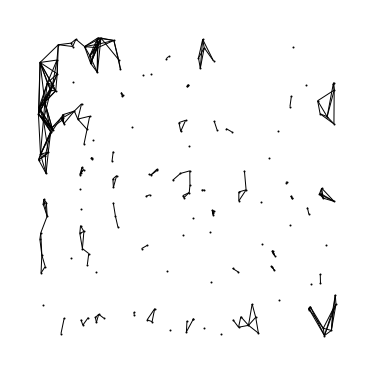

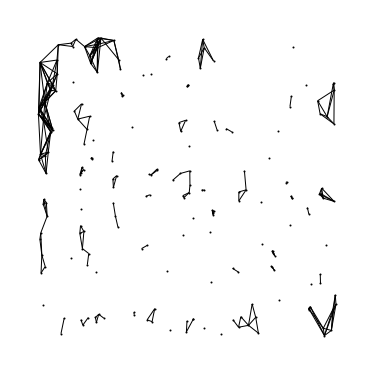

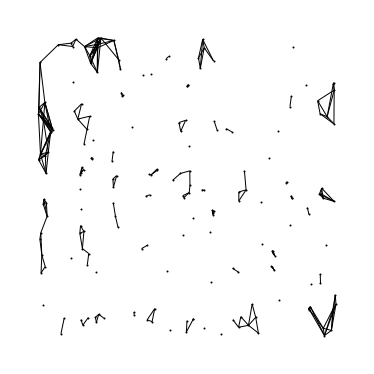

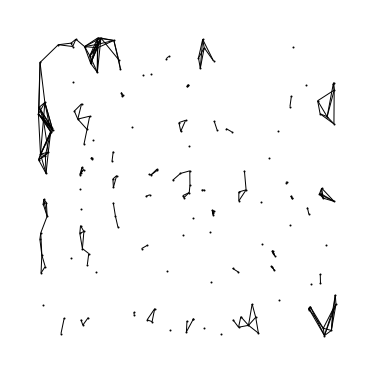

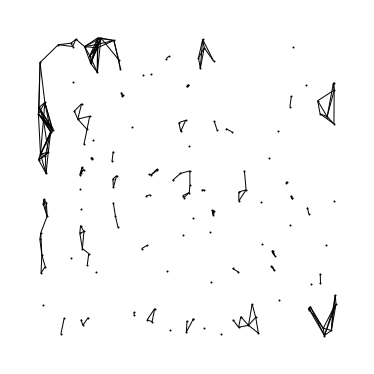

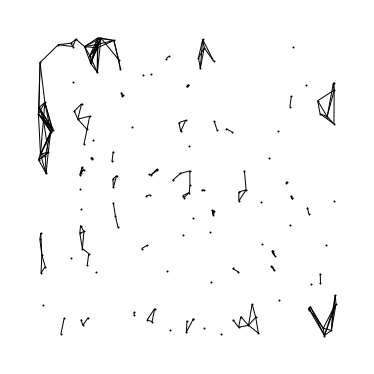

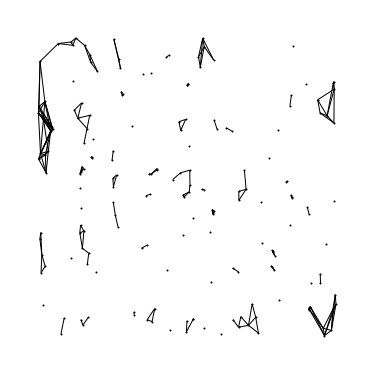

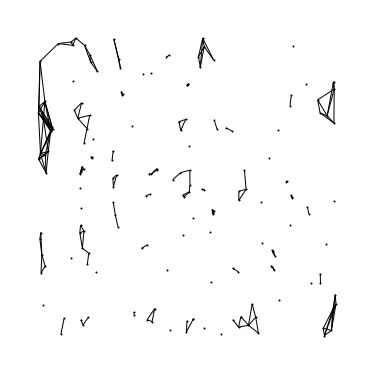

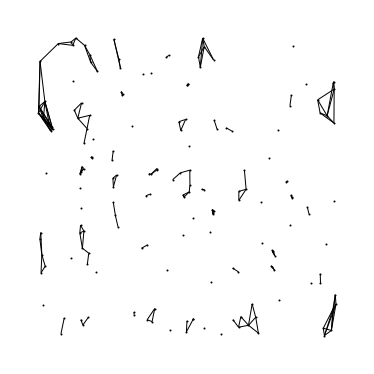

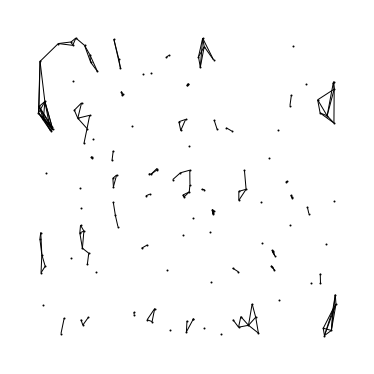

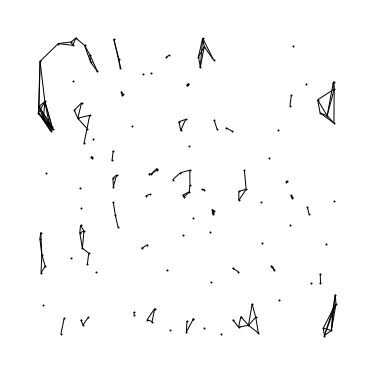

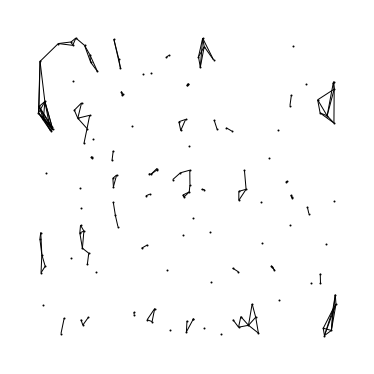

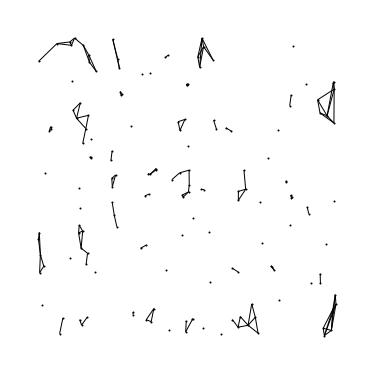

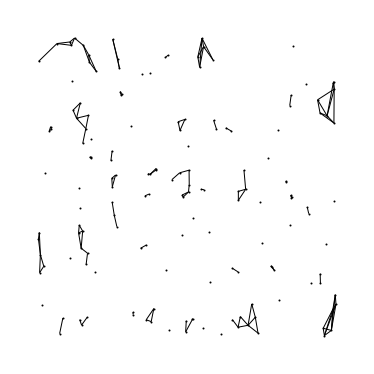

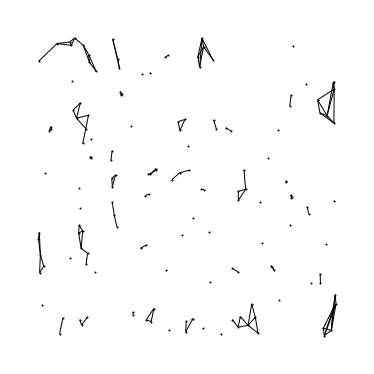

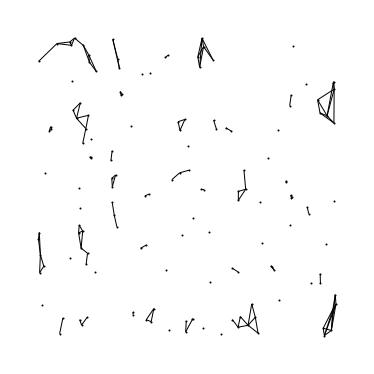

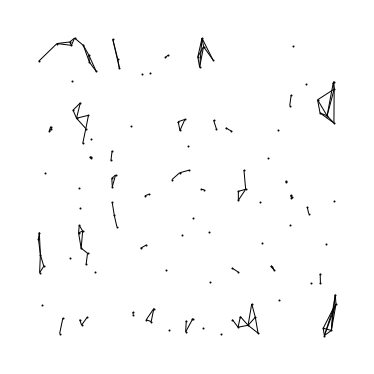

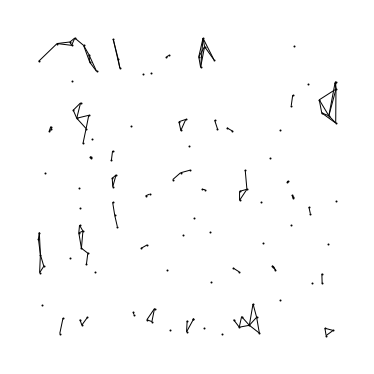

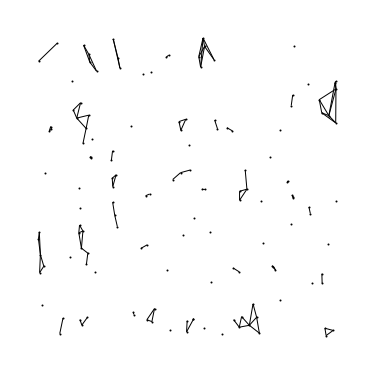

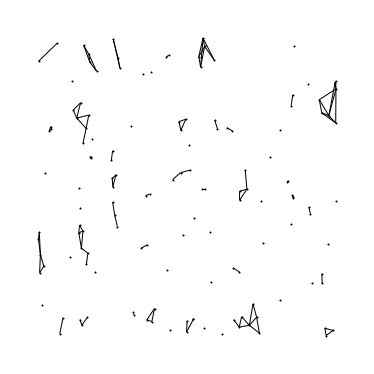

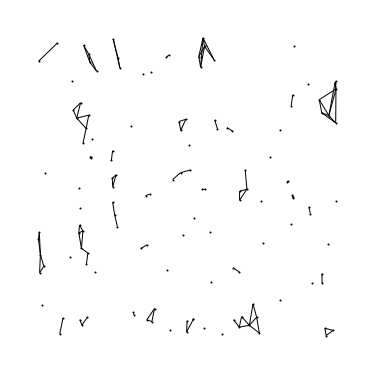

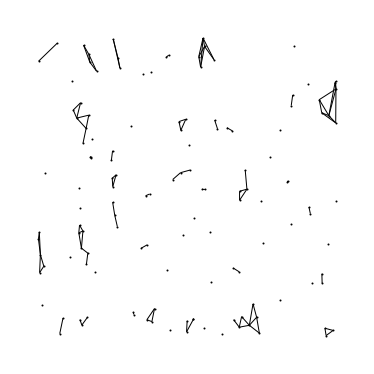

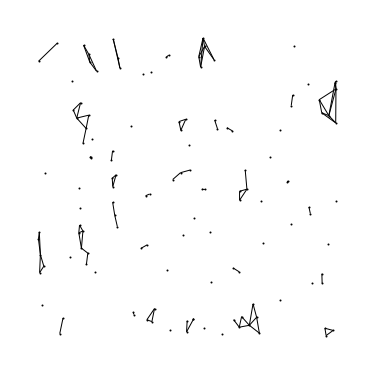

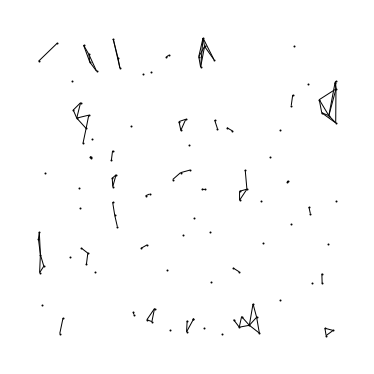

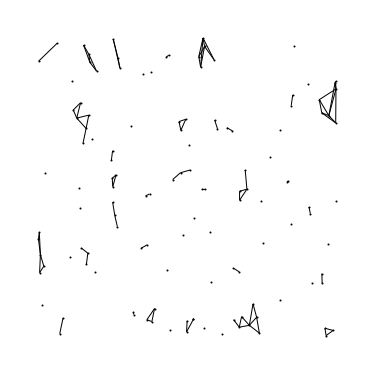

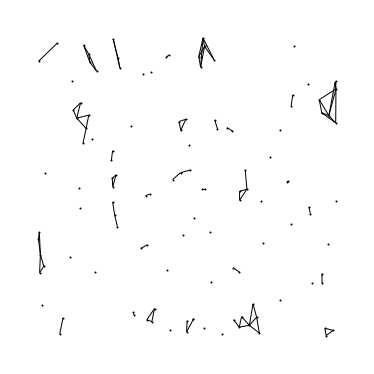

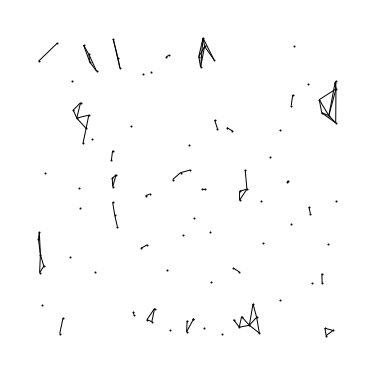

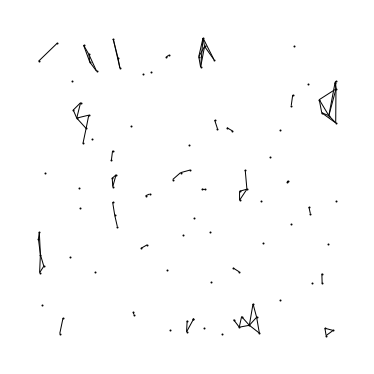

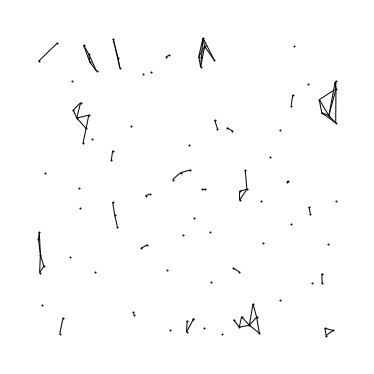

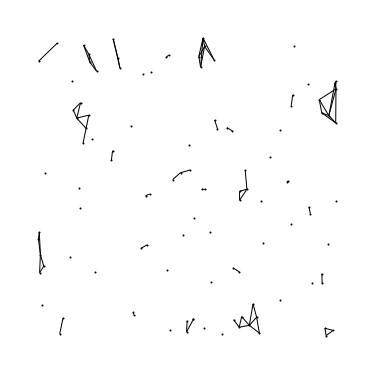

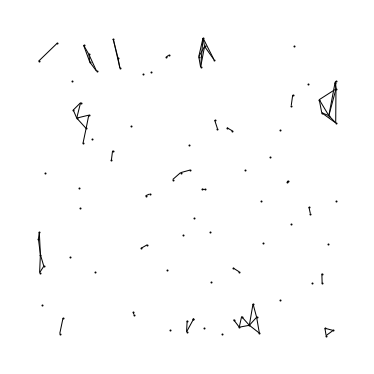

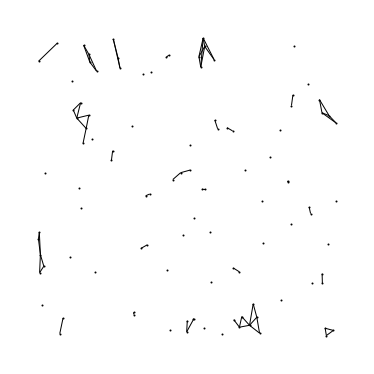

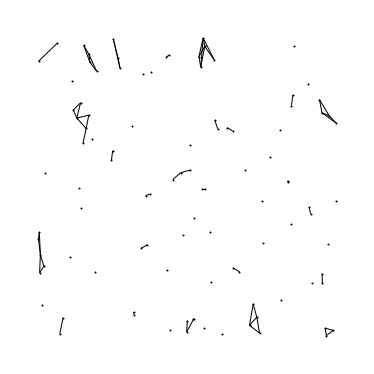

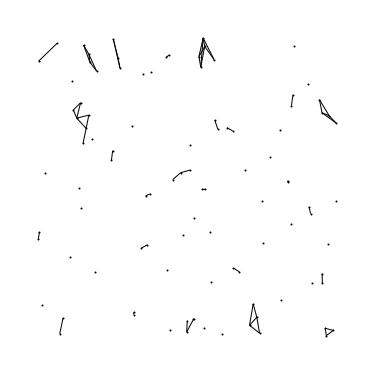

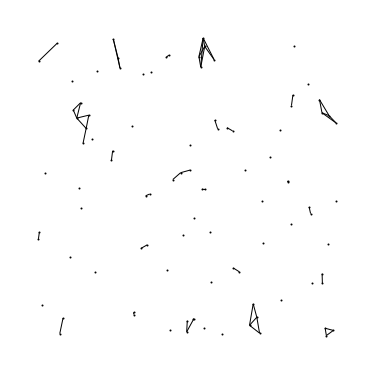

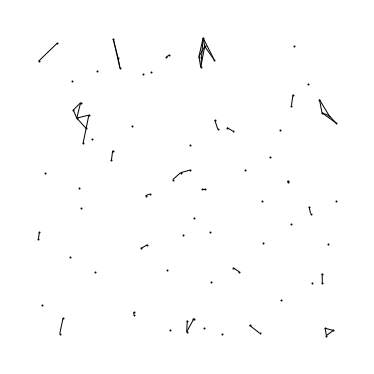

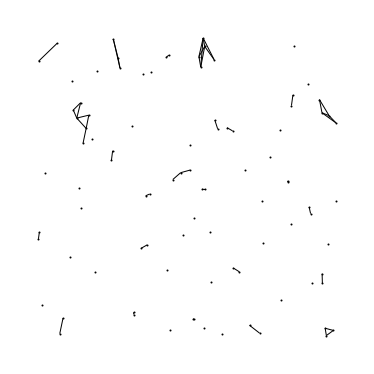

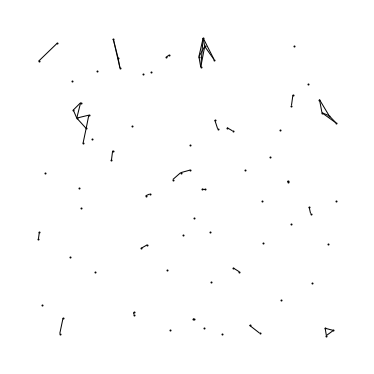

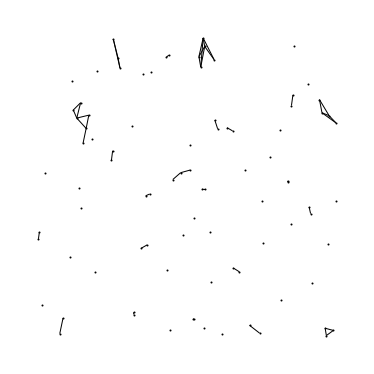

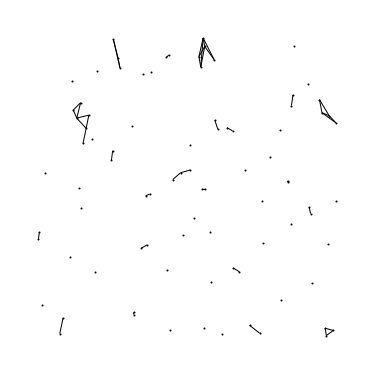

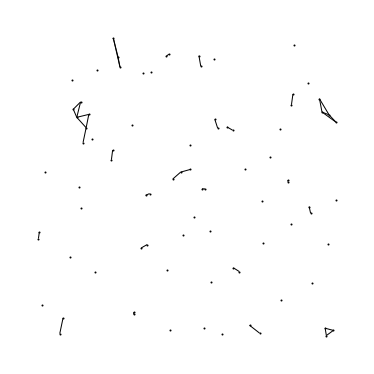

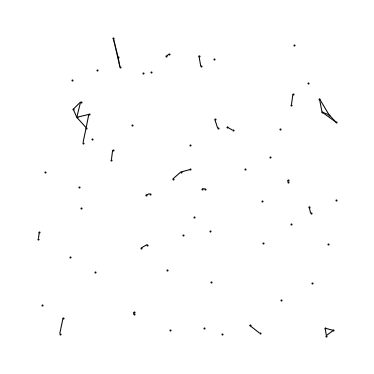

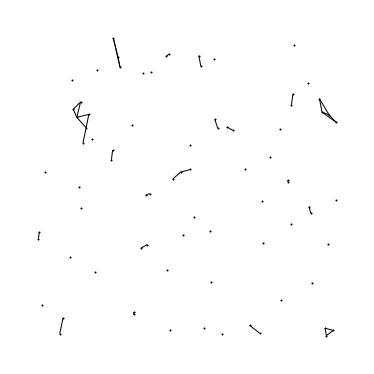

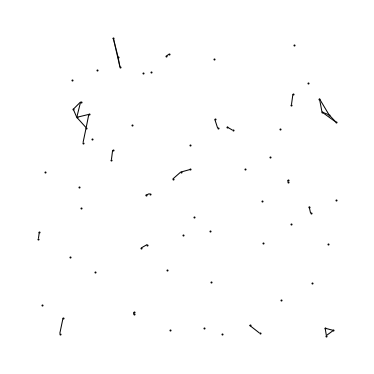

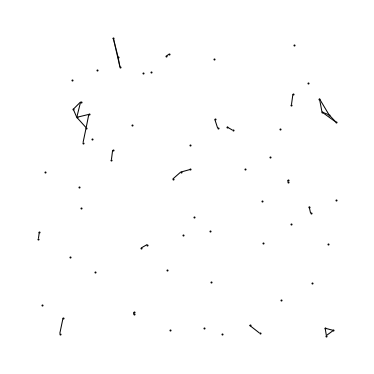

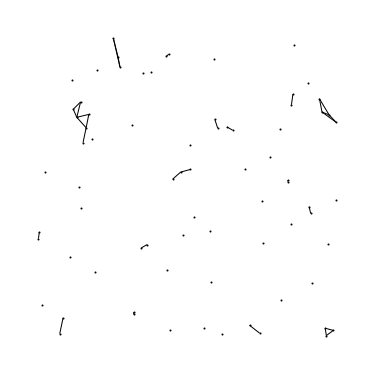

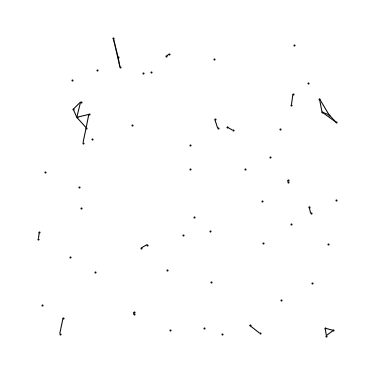

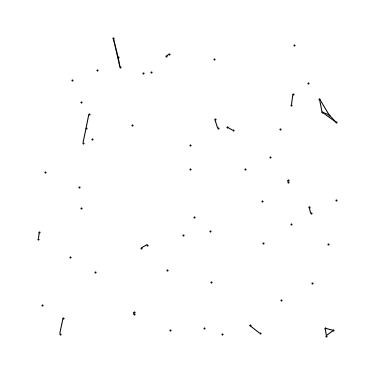

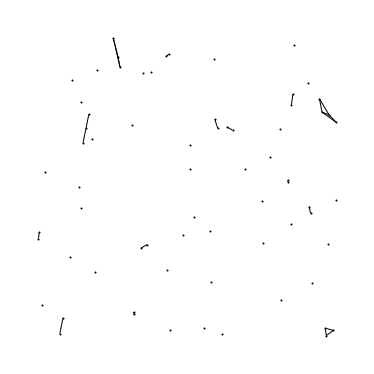

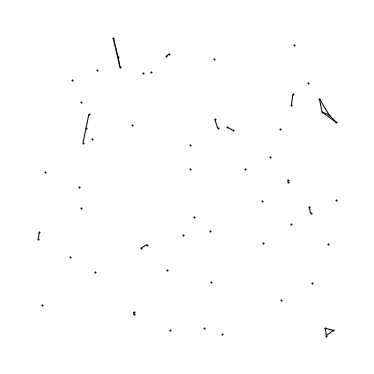

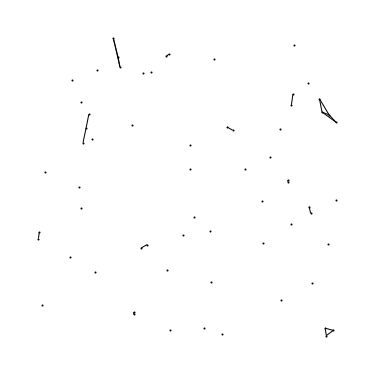

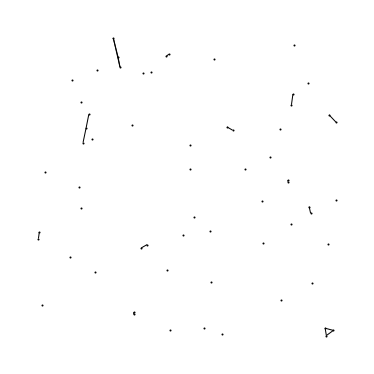

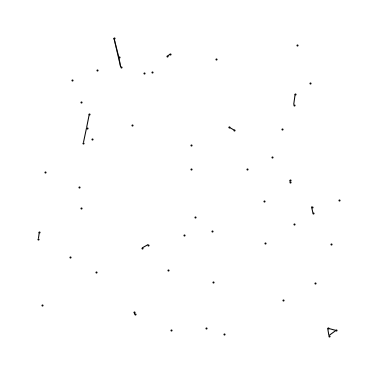

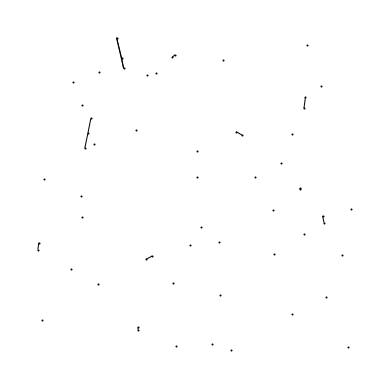

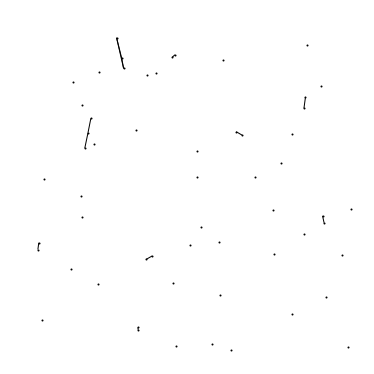

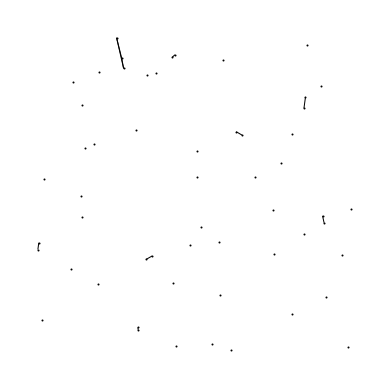

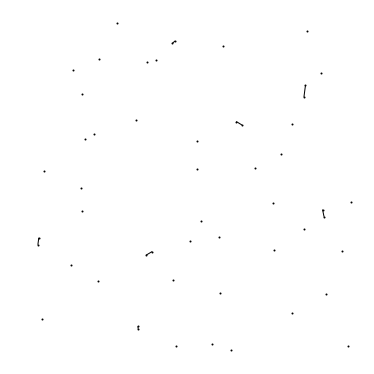

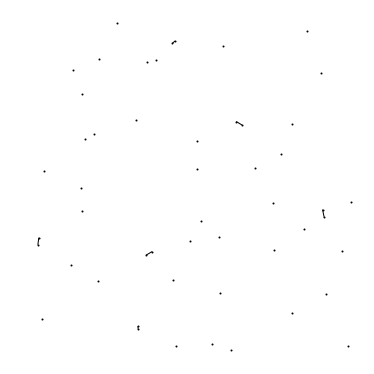

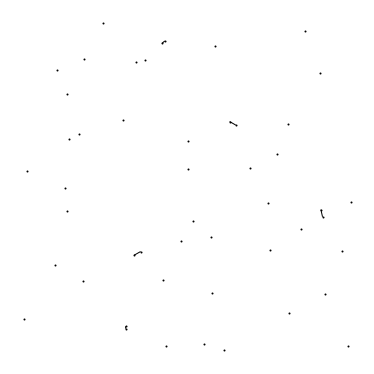

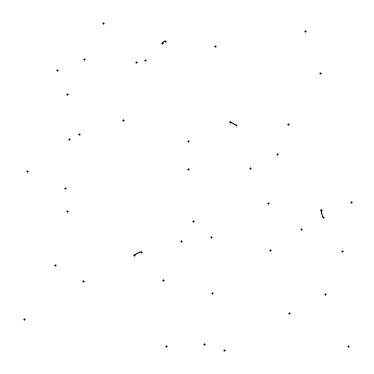

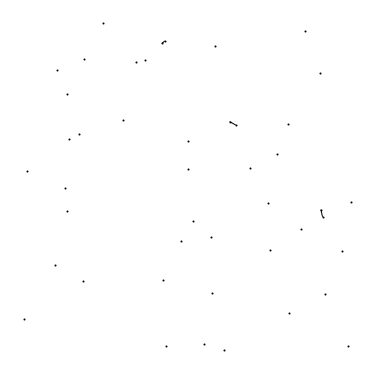

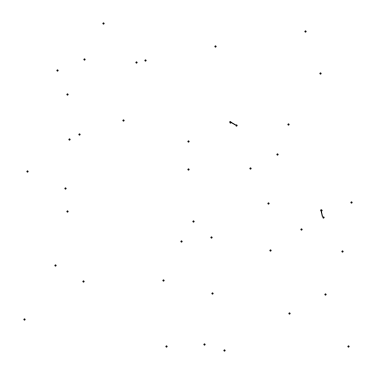

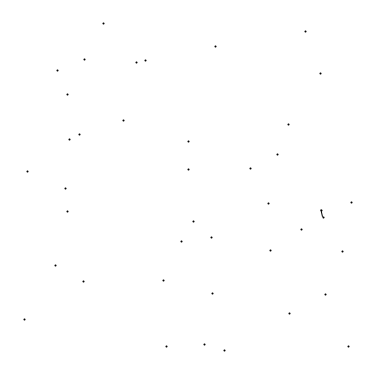

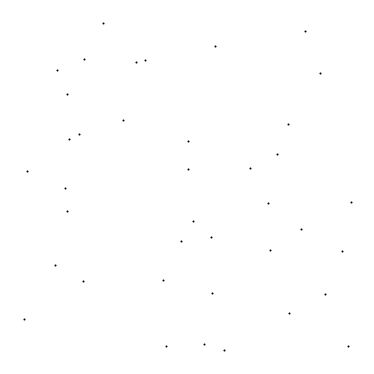

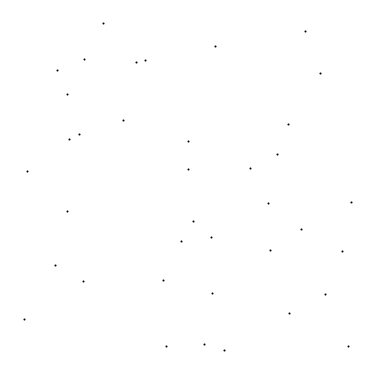

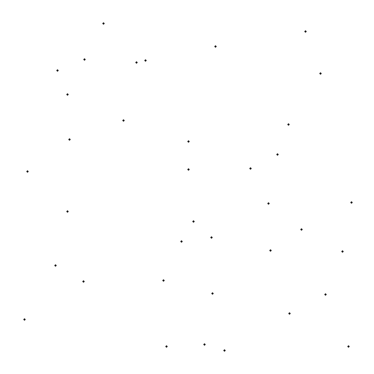

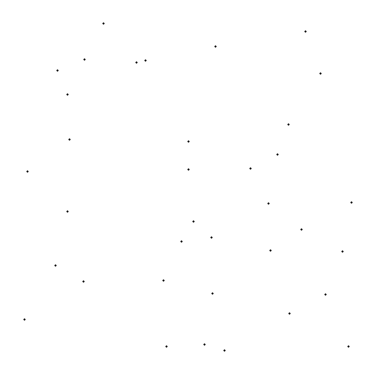

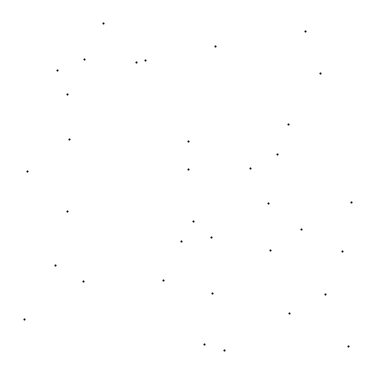

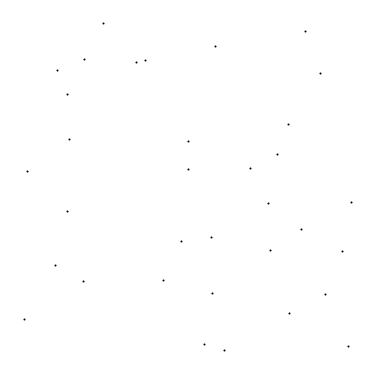

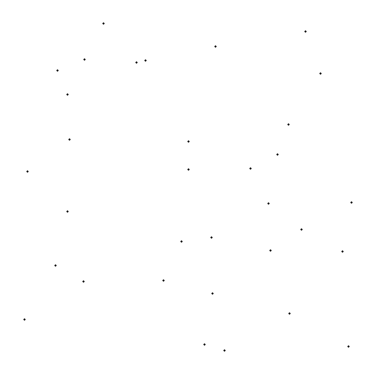

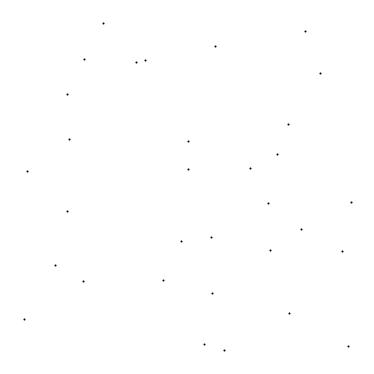

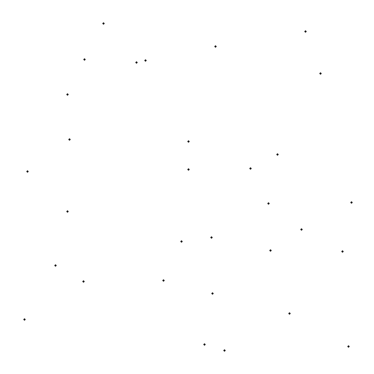

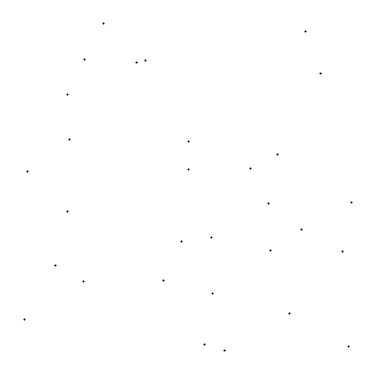

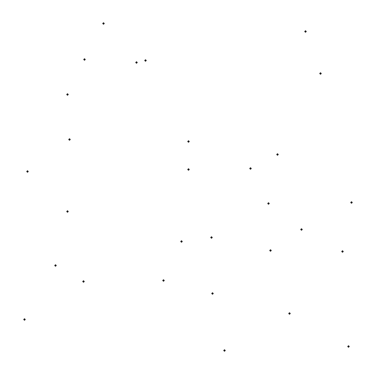

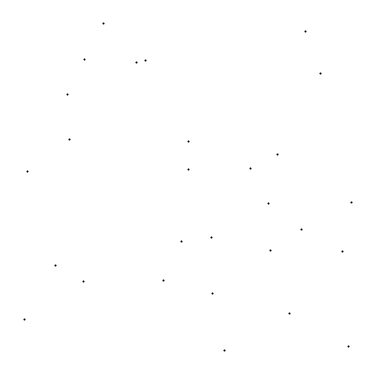

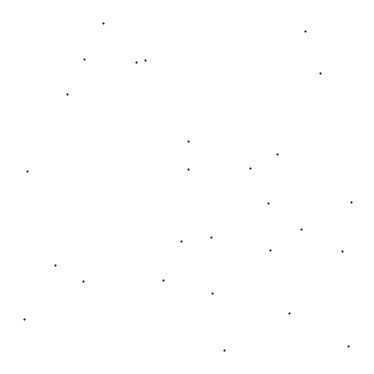

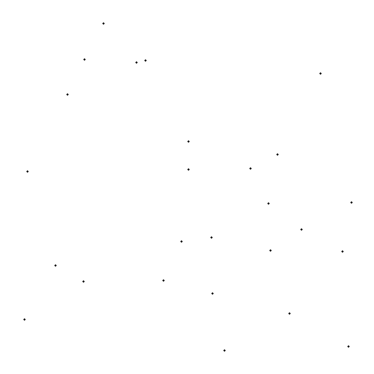

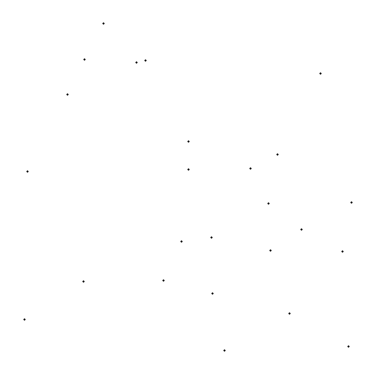

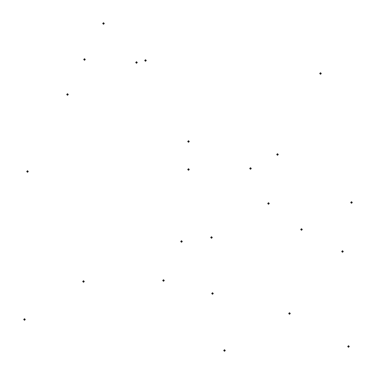

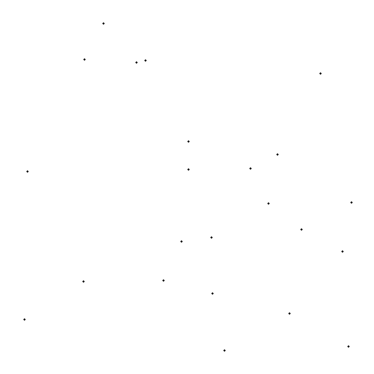

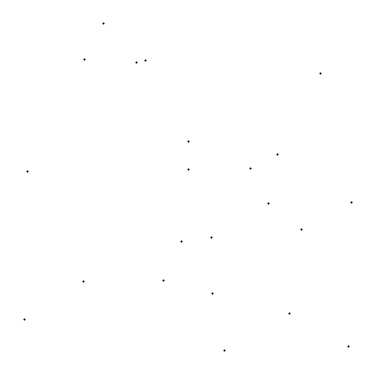

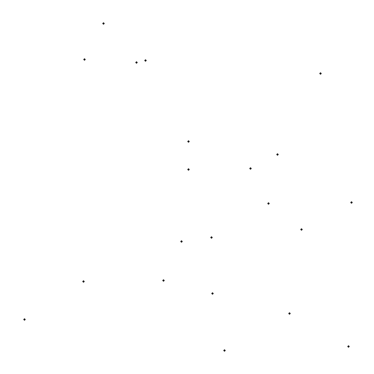

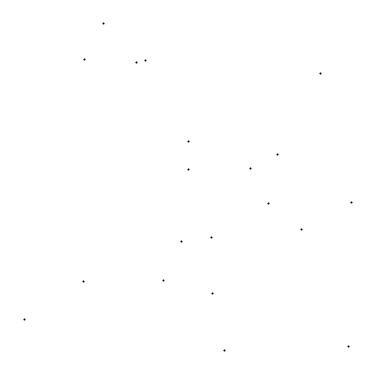

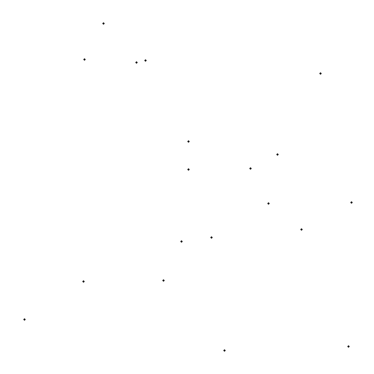

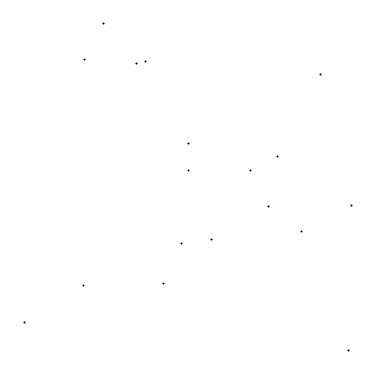

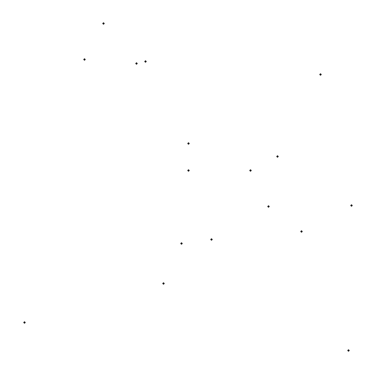

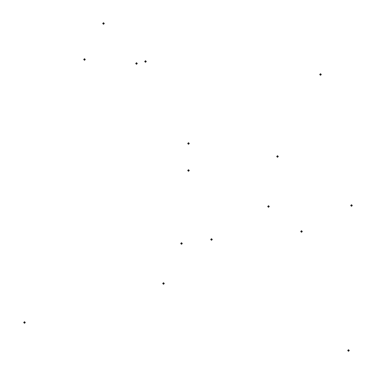

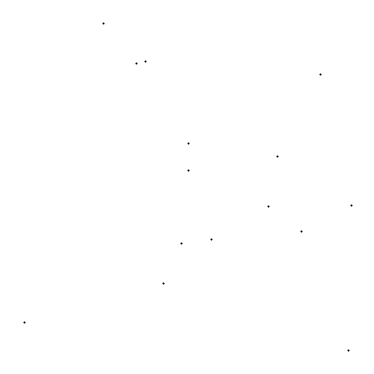

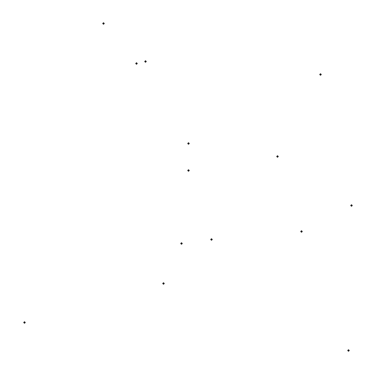

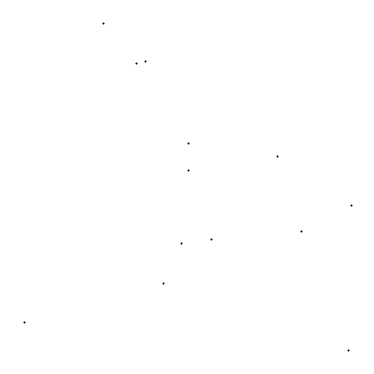

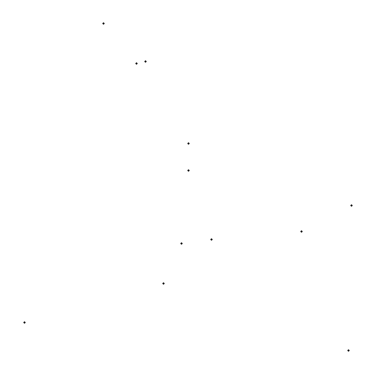

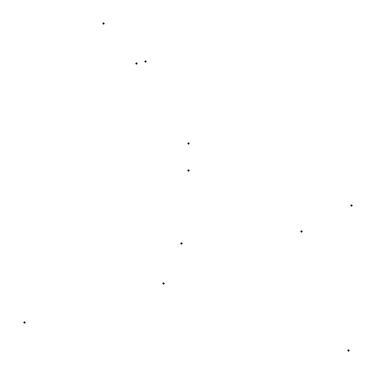

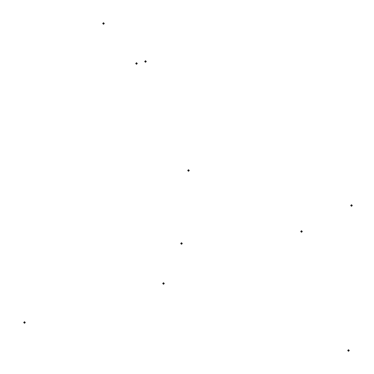

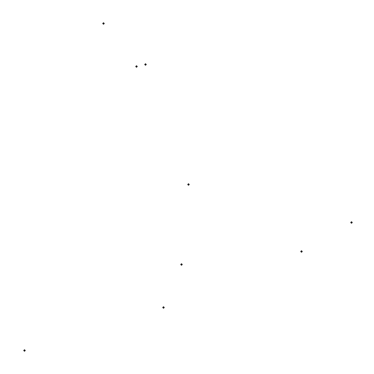

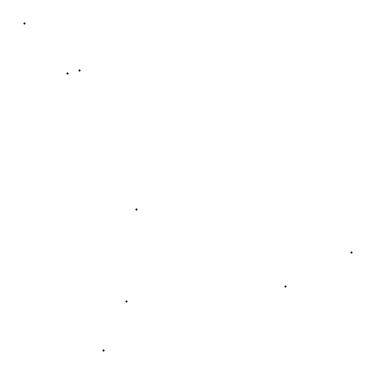

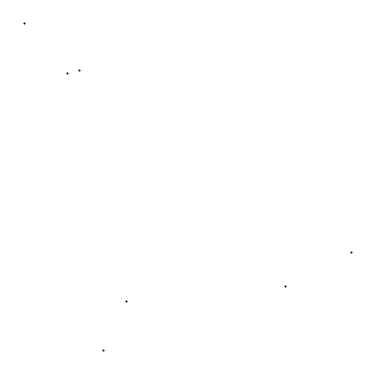

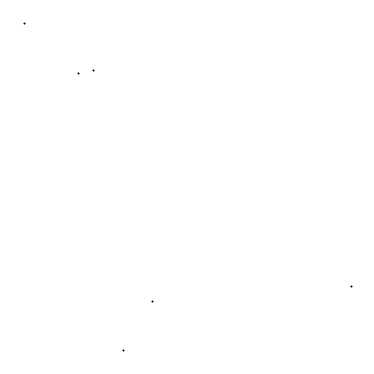

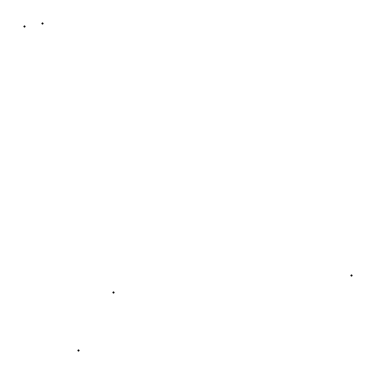

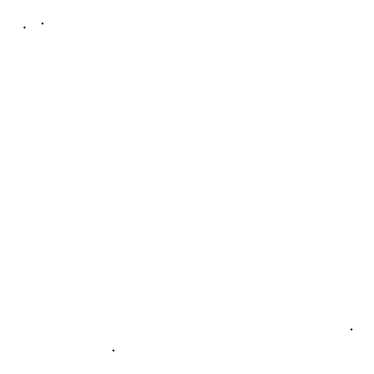

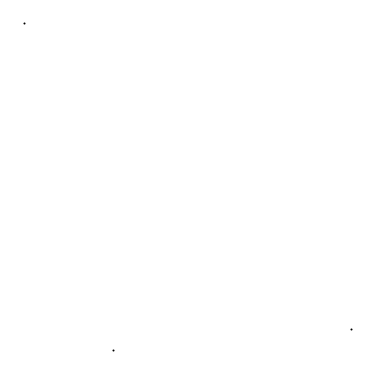

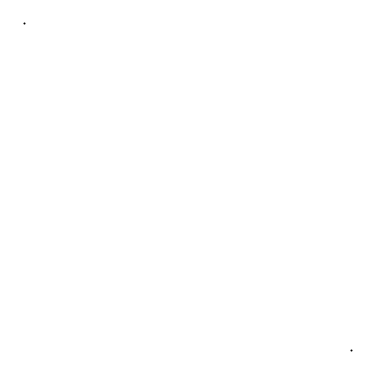

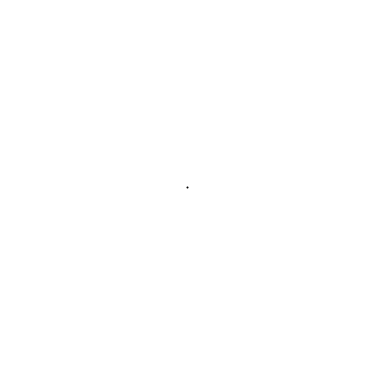

In [8]:
clusters = np.zeros(len(X))
cluster_idx = 1

curr = set(range(len(X)))
blacklist = set()

knng_original = build_k_nearest_neighbor_graph(curr, k, distance_matrix)
knng = knng_original.copy()

#while len(curr) > 0:
while len(knng.nodes()) > 0:
    #knng = build_k_nearest_neighbor_graph(curr, k=k)
    knng_copy = knng.copy()

    plt.figure(figsize=(5, 5))
    nx.draw(knng, pos=X, node_size=1, node_color="black")
    plt.show()

    N_remove = len(knng.edges()) // 2
    i = 0
    for a, b, w in sorted(knng.edges(data=True), key=lambda x: x[2].get("weight", 1), reverse=True):
        if i >= N_remove:
            break

        if knng.has_edge(a, b):
            if knng.degree(a) > 1:
                knng.remove_edge(a, b)
                i += 1

        if knng.has_edge(b, a):
            if knng.degree(b) > 1:
                knng.remove_edge(b, a)
                i += 1

    subgraphs = sorted(list(nx.connected_components(knng)), key=lambda t: len(t), reverse=True)

    if len(subgraphs) > 0:
        subgraph_vertices = subgraphs[0]

        #blacklist.update(subgraph_vertices)
        #curr = set(range(len(X))) - blacklist
        knng_copy.remove_nodes_from(subgraph_vertices)

        clusters[list(subgraph_vertices)] = cluster_idx

    cluster_idx += 1
    knng = knng_copy

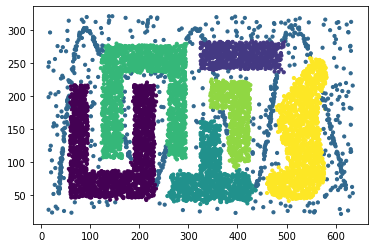

In [9]:
plt.scatter(df["x"], df["y"], c=df["CLASS"], s=10)

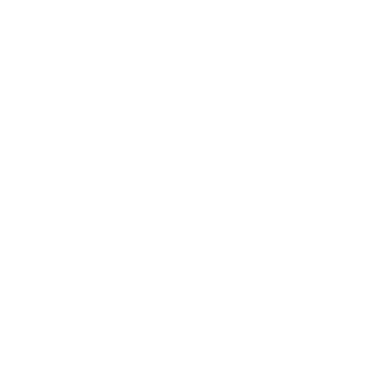

In [10]:
plt.figure(figsize=(5, 5))
nx.draw(knng, pos=X, node_size=1, node_color="black")
plt.show()

In [85]:
knng = knng_original.copy()

cache = {
    "absolute_interconnectivity": {},
    "internal_interconnectivity": {},
    "absolute_closeness": {},
    "internal_closeness": {},
}

def absolute_interconnectivity(i, j):
    if (i, j) in cache["absolute_interconnectivity"]:
        return cache["absolute_interconnectivity"][(i, j)]

    if (j, i) in cache["absolute_interconnectivity"]:
        return cache["absolute_interconnectivity"][(j, i)]

    nodes_i = np.where(clusters == i)[0].tolist()
    nodes_j = np.where(clusters == j)[0].tolist()

    edges_i = knng.subgraph(nodes_i).copy().edges(data=True)
    edges_j = knng.subgraph(nodes_j).copy().edges(data=True)

    cluster_connector = knng.subgraph(nodes_i + nodes_j).copy()
    cluster_connector.remove_edges_from(edges_i)
    cluster_connector.remove_edges_from(edges_j)

    result = cluster_connector.size(weight="weight")

    cache["absolute_interconnectivity"][(i, j)] = result

    return result


def internal_interconnectivity(i):
    if i in cache["internal_interconnectivity"]:
        return cache["internal_interconnectivity"][i]

    nodes = np.where(clusters == i)[0].tolist()

    cluster = knng.subgraph(nodes).copy()

    if cluster.number_of_nodes() <= 0 or cluster.number_of_edges() <= 0:
        return 0

    a, b = community.kernighan_lin_bisection(cluster, weight="similarity", seed=42)

    edges_a = cluster.subgraph(a).copy().edges(data=True)
    edges_b = cluster.subgraph(b).copy().edges(data=True)

    cluster.remove_edges_from(edges_a)
    cluster.remove_edges_from(edges_b)

    result = cluster.size(weight="weight")

    cache["internal_interconnectivity"][i] = result

    return result


def relative_interconnectivity(i, j):
    ec_i_j = absolute_interconnectivity(i, j)
    ec_i = internal_interconnectivity(i)
    ec_j = internal_interconnectivity(j)

    return 2 * ec_i_j / (ec_i + ec_j + 1e-6)


#temp = list(itertools.combinations(np.unique(clusters).astype(np.uint8), 2))
#for i, j in tqdm(temp):
#    print(i, j, relative_interconnectivity(i, j))

In [94]:
def absolute_closeness(i, j):
    if (i, j) in cache["absolute_closeness"]:
        return cache["absolute_closeness"][(i, j)]

    if (j, i) in cache["absolute_closeness"]:
        return cache["absolute_closeness"][(j, i)]

    nodes_i = np.where(clusters == i)[0].tolist()
    nodes_j = np.where(clusters == j)[0].tolist()

    edges_i = knng.subgraph(nodes_i).copy().edges(data=True)
    edges_j = knng.subgraph(nodes_j).copy().edges(data=True)

    cluster_connector = knng.subgraph(nodes_i + nodes_j).copy()
    cluster_connector.remove_edges_from(edges_i)
    cluster_connector.remove_edges_from(edges_j)

    result = cluster_connector.size(weight="weight") / (cluster_connector.number_of_edges() + 1e-6)

    cache["absolute_closeness"][(i, j)] = result

    return result


def internal_closeness(i):
    if i in cache["internal_closeness"]:
        return cache["internal_closeness"][i]

    nodes = np.where(clusters == i)[0].tolist()

    cluster = knng.subgraph(nodes).copy()

    if cluster.number_of_nodes() <= 0 or cluster.number_of_edges() <= 0:
        return 0

    a, b = community.kernighan_lin_bisection(cluster, weight="similarity", seed=42)

    edges_a = cluster.subgraph(a).copy().edges(data=True)
    edges_b = cluster.subgraph(b).copy().edges(data=True)

    cluster.remove_edges_from(edges_a)
    cluster.remove_edges_from(edges_b)

    result = cluster.size(weight="weight") / (cluster.number_of_edges() + 1e-6)

    cache["internal_closeness"][i] = result

    return result


def relative_closeness(i, j):
    s_i_j = absolute_closeness(i, j)
    s_i = internal_closeness(i)
    s_j = internal_closeness(j)
    n_i = len(np.where(clusters == i)[0].tolist())
    n_j = len(np.where(clusters == j)[0].tolist())

    return s_i_j / ((n_i / (n_i + n_j + 1e-6)) * s_i + (n_j / (n_i + n_j + 1e-6)) * s_j + 1e-6)


temp = list(itertools.combinations(np.unique(clusters).astype(np.uint8), 2))
for i, j in tqdm(temp):
    t = relative_closeness(i, j)
    if t > 5:
        print(i, j, t)

  0%|          | 0/9453 [00:00<?, ?it/s]

1 34 5.119695656118671
1 44 5.370589356001247
2 42 7.2938506628367215
2 133 7.8909042824949625
3 84 5.039190713473844
4 84 5.337411082160078
5 76 6.366756024460668
43 89 8.841423174475098


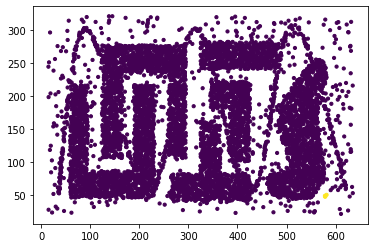

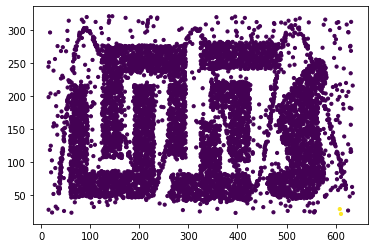

In [95]:
plt.scatter(df["x"], df["y"], c=(clusters == 43), s=10)
plt.show()
plt.scatter(df["x"], df["y"], c=(clusters == 89), s=10)
plt.show()

In [14]:
#plt.scatter(df["x"], df["y"], c=clusters, s=10)
#plt.show()

#for i in range(cluster_idx):
#    plt.scatter(df["x"], df["y"], c=(clusters == i), s=10)
#    plt.show()